In [2]:
import numpy
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from importlib import reload
import InputList
import BinaryReader
import Preprocessor
import models
import Callbacks

2022-02-15 14:36:29.037901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-15 14:36:31.034232: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-15 14:36:31.034277: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-15 14:36:31.035016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-15 14:36:31.142467: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 2 GPUs
2022-02-15 14:36:31.143207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-02-15 14:36:31.144369: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-15 14:36:31.144558: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed

In [4]:
reload(BinaryReader)

<module 'BinaryReader' from '/home/juliusmlcaesar/PycharmProjects/oct-classifier/BinaryReader.py'>

In [3]:
import InputListUtils
InputListUtils.generate_diabetic_files_list()

## Make this such that it can be used for prediction and training pipeline

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
reader = BinaryReader.BinaryReader()  # TODO: Normalizer
training_dataset, validation_dataset = reader.create_training_datasets(InputList.training_files)
preprocesser = Preprocessor.Preprocessor(training_dataset)

2022-02-15 14:37:03.228579: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-15 14:37:03.231504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-15 14:37:03.233808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:21:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-15 14:37:03.233855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-15 14:37:03.235751: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-15 14:37:03.2358

Num GPUs Available:  2
[('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D94/links/raw_1536x2048x2045x2_2563.bin', 1), ('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/H6/rechts/raw_1536x2048x2045x2_8042.bin', 0), ('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/H5/raw_1536x2048x2045x2_17600.bin', 0), ('/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D85/rechts/raw_1536x2048x2045x2_19200.bin', 1)]


2022-02-15 14:37:03.467795: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-15 14:37:03.826119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-15 14:37:03.827752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:21:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-15 14:37:03.827853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49

In [6]:
print("Creating Normalization Layer:")
normalization_layer = preprocesser.normalize_layer()

Creating Normalization Layer:


2022-02-15 14:37:11.605627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-15 14:37:11.625640: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2399700000 Hz


In [7]:
#normalization_weights = normalization_layer.get_weights()
#print("Before:" + str(normalization_weights))
# normalization_weights_path = "results/normalization.npy"
# #np.save(normalization_weights_path, normalization_weights)
# normalization_layer.set_weights(np.load(normalization_weights_path))
# print("After" + str(normalization_layer.get_weights()))

In [7]:
model = models.RawClassifier().model()(training_dataset.element_spec[0].shape, normalization_layer, reconstruction=False)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536, 102, 102, 1 0         
_________________________________________________________________
normalization (Normalization (None, 1536, 102, 102, 1) 3         
_________________________________________________________________
conv3d (Conv3D)              (None, 1536, 102, 102, 32 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 768, 51, 51, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 768, 51, 51, 64)   55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 384, 25, 25, 64)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 384, 25, 25, 96)   165984

In [8]:
a = len(InputList.diabetic_training_files)
b = len(InputList.healthy_training_files)
class_weights = {0: (1/b) * (a+b)/2, 1:(1/a) * (a+b)/2}
class_weights

{0: 13.666666666666666, 1: 0.5189873417721519}

In [ ]:
history = model.fit(
    preprocesser.batch(1),
    epochs=10,
    validation_data=Preprocessor.Preprocessor(validation_dataset).batch(1),
    callbacks=Callbacks.my_callbacks,
    class_weight=class_weights,
)
model.save('savedModels/first')

Epoch 1/10


2022-02-15 14:37:50.100564: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-02-15 14:37:50.100606: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-02-15 14:37:50.100820: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-02-15 14:37:50.698052: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-15 14:37:57.483120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


      6/Unknown - 20s 386ms/step - loss: 12.6042WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1363s vs `on_train_batch_end` time: 0.2106s). Check your callbacks.
     20/Unknown - 25s 367ms/step - loss: 9.3162

2022-02-15 14:38:14.792769: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-02-15 14:38:14.827757: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-02-15 14:38:14.838947: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-02-15 14:38:14.853728: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20220215-143631/train/plugins/profile/2022_02_15_14_38_14
2022-02-15 14:38:14.863730: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20220215-143631/train/plugins/profile/2022_02_15_14_38_14/hyperion-vie.trace.json.gz
2022-02-15 14:38:14.914754: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20220215-143631/train/plugins/profile/2022_02_15_14_38_14
2022-02-15 14:38:14.922093: I tensorflow/core

   8512/Unknown - 7599s 891ms/step - loss: 2.9339

In [69]:
reader.create_test_dataset([("/mnt/NewHDD/train_data/raw_1536x2048x2045x2_9201.bin", 0)])

In [4]:
new_model = tf.keras.models.load_model('savedModels/second')

In [ ]:
wrong_healthy_file = reader.create_test_dataset([InputList.healthy_training_files[0]])
output_healthy = new_model.predict(wrong_healthy_file.batch(2))

Cause: could not parse the source code of <function BinaryReader.create_dataset.<locals>.<lambda> at 0x7fc1ec1a35e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function BinaryReader.create_dataset.<locals>.<lambda> at 0x7fc1ec1a35e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [44]:
output

array([[10.267875 ],
       [10.267875 ],
       [10.384956 ],
       [10.384956 ],
       [10.637013 ],
       [10.637013 ],
       [10.932584 ],
       [10.932584 ],
       [10.280084 ],
       [10.280084 ],
       [11.147074 ],
       [11.147074 ],
       [10.868604 ],
       [10.868604 ],
       [11.568986 ],
       [11.568986 ],
       [10.530014 ],
       [10.530014 ],
       [11.258928 ],
       [11.258928 ],
       [10.46459  ],
       [10.46459  ],
       [10.925874 ],
       [10.925874 ],
       [10.61441  ],
       [10.61441  ],
       [11.452877 ],
       [11.452877 ],
       [11.004479 ],
       [11.004479 ],
       [11.437254 ],
       [11.437254 ],
       [10.570957 ],
       [10.570957 ],
       [10.738581 ],
       [10.738581 ],
       [10.360428 ],
       [10.360428 ],
       [10.786953 ],
       [10.786953 ],
       [11.025751 ],
       [11.025751 ],
       [11.665013 ],
       [11.665013 ],
       [10.663699 ],
       [10.663699 ],
       [11.076247 ],
       [11.07

In [17]:
test_dataset = reader.create_test_dataset([InputList.diabetic_testing_files[0]])
output_test = new_model.predict(test_dataset.batch(2))

In [45]:
output_healthy_val

NameError: name 'output_healthy_val' is not defined

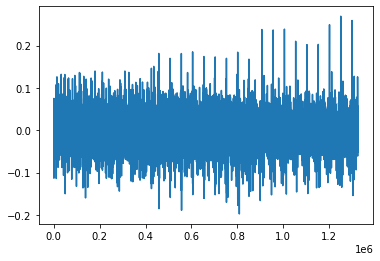

In [42]:
import matplotlib.pyplot as plt
plt.plot(new_model.layers[-4].get_weights()[0].flatten())

In [ ]:
a = (20, 1536, 102, 102, 64)

In [37]:
test_dataset = reader.create_test_dataset([InputList.healthy_training_files[4]])
output_healthy_val = new_model.predict(test_dataset.batch(20), callbacks=Callbacks.tboard_callback)

In [39]:
test_dataset = reader.create_test_dataset([("/mnt/NewHDD/train_data/raw_1536x2048x2045x2_9201.bin", 0)])
output_some_file = new_model.predict(test_dataset.batch(20), callbacks=Callbacks.tboard_callback)

KeyboardInterrupt: 

In [28]:
test_dataset = reader.create_test_dataset([InputList.healthy_testing_files[0]])
output_healthy_test = new_model.predict(test_dataset.batch(20))

In [6]:
test_dataset = reader.create_test_dataset([InputList.diabetic_testing_files[0]])
output_diabetic_test = new_model.predict(test_dataset.batch(20))

2022-02-10 09:57:10.869736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-10 09:57:10.886408: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
2022-02-10 09:57:12.287878: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:17.295475: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:22.651924: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:28.308051: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-10 09:57:33.802789: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.


In [32]:
np.max(output_test)

3.9775429

In [9]:
with open("instance_test/output_buffer.npy", "wb") as f:
    np.save(f, output_diabetic_test)

In [10]:
with open("instance_test/output_buffer.npy", "rb") as f:
    buffi = np.load(f)

In [11]:
buffi

array([[6.119612 ],
       [6.305094 ],
       [7.2212224],
       ...,
       [6.104448 ],
       [6.5245843],
       [6.7683864]], dtype=float32)

In [33]:
import Visualization
reload(Visualization)
testing_diabetic_image = Visualization.ImageVisualizer(output_test,
                                                       info_map=None,
                                                       background_image_path=
                                                       "/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D71/rechts/retina_1536x2048x2045x2_2375.png"
                                                       , instance_size=(102, 102, 20, 20))
testing_diabetic_image.plot_results_map("diabetic_test")

In [49]:
testing_healthy_image = Visualization.ImageVisualizer(output_healthy_test,
                                                       info_map=None,
                                                       background_image_path=
                                                       "/mnt/p_Zeiss/Projects/UWF OCTA/Clinical data/MOON1/D71/rechts/retina_1536x2048x2045x2_2375.png")
testing_healthy_image.plot_results_map("healthy_test")

In [ ]:
output_healthy_val

In [ ]:
i = 1

In [1]:
np.argmax(output_diabetic_test)

NameError: name 'np' is not defined

In [ ]:
reload(models)
model = models.classiRaw3D(training_dataset.element_spec[0].shape, normalization_layer, reconstruction=False)

In [224]:
training_dataset

<PrefetchDataset shapes: ((1536, 23, 28, 1), ()), types: (tf.uint16, tf.uint8)>

In [8]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [18]:
model.load_weights("checkpoints/best_model")

In [12]:
with open("checkpoints/best_model.data-00000-of-00001") as testi:
    print(testi)

<_io.TextIOWrapper name='checkpoints/best_model.data-00000-of-00001' mode='r' encoding='UTF-8'>


print_function(Bag Number, dataset)

-> In einem Bag sind 7000 Instanzen

# Bag Level Model:

Ich hab ganz viele Softmaxes und von denen nehm ich einfach den Max Wert

In [68]:
test_dataset = reader.create_test_dataset([InputList.diabetic_training_files[4]])
output = model.predict(test_dataset.batch(20))

2022-02-08 18:00:53.002220: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:00:57.834422: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:03.134897: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:08.671641: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:14.168709: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
